### Exploración datos de coordenadas para el MAPA


In [1]:
import pandas as pd

df = pd.read_csv('../../data/ex2/preprocess_mapa_1_min.csv')
df['date_time'] = pd.to_datetime(df['ts_kafka'],unit='ms')

In [2]:
df.head()

,ts_kafka,velocity,lat,lon,icao,ground,direccion,alt_feet,callsign,vortex,date_time
0,1.733039e+12,NaN,NaN,NaN,34110b,NaN,NaN,NaN,SSE8____,Surface emergency vehicle,2024-12-01 07:46:50.767
1,1.733039e+12,NaN,NaN,NaN,34110b,NaN,NaN,NaN,SSE8____,Surface emergency vehicle,2024-12-01 07:47:49.507
2,1.733039e+12,NaN,NaN,NaN,34110b,NaN,NaN,NaN,SSE8____,Surface emergency vehicle,2024-12-01 07:48:53.279
3,1.733039e+12,NaN,NaN,NaN,34110b,NaN,NaN,NaN,SSE8____,Surface emergency vehicle,2024-12-01 07:49:50.334
4,1.733039e+12,NaN,NaN,NaN,34110b,NaN,NaN,NaN,SSE8____,Surface emergency vehicle,2024-12-01 07:50:51.088


In [3]:
icaos_con_varios_tipos = df[['icao', 'vortex', 'ts_kafka']].drop_duplicates().dropna()
icaos_con_varios_tipos = icaos_con_varios_tipos[icaos_con_varios_tipos['vortex'] != 'No category information']

icaos_con_varios_tipos.pivot_table('ts_kafka', 'icao', 'vortex', aggfunc='count').sum(axis=0)

vortex
\tGlider, sailplane                                                   2.0
ERROR                                                             88517.0
Ground obstruction                                                    9.0
Heavy (larger than 136000 kg)                                     83115.0
High performance (>5 g acceleration) and high speed (>400 kt)         5.0
High vortex aircraft                                               1669.0
Light (less than 7000 kg)                                         14165.0
Lighter-than-air                                                      3.0
Medium 1 (between 7000 kg and 34000 kg)                           20505.0
Medium 2 (between 34000 kg to 136000 kg)                         481924.0
Parachutist, skydiver                                                 2.0
Reserved                                                             15.0
Rotorcraft                                                         1686.0
Space or transatmospheric vehic

In [4]:
icaos_con_varios_tipos = df[['icao', 'vortex']].drop_duplicates().dropna()
icaos_con_varios_tipos = icaos_con_varios_tipos[icaos_con_varios_tipos['vortex'] != 'No category information']
icaos_con_varios_tipos = icaos_con_varios_tipos.groupby('icao').agg({'vortex': 'count'})
icaos_con_varios_tipos = icaos_con_varios_tipos[icaos_con_varios_tipos['vortex'] > 1]
icaos_con_varios_tipos.sort_values(by='vortex', ascending=False)

,vortex
icao,
3c49ec,2


In [5]:
temp = df[['icao', 'vortex']].drop_duplicates()
temp[temp.icao == '3c49ec']

,icao,vortex
678280,3c49ec,Medium 2 (between 34000 kg to 136000 kg)
678291,3c49ec,NaN
678301,3c49ec,High vortex aircraft


### Latitud y Longitud

Vemos la cantidad de valores vacíos

In [6]:
df.shape

(952775, 11)

In [7]:
df.isna().sum()

ts_kafka          0
velocity     406585
lat          406012
lon          406012
icao              0
ground       376933
direccion    415376
alt_feet     413246
callsign     128980
vortex       128975
date_time         0
dtype: int64

Aparecen **muchos valores vacios**, eliminamos aquellos que no tienen latitud ni longitud

**Correlaciones entre los nulos de diferentes columnas**

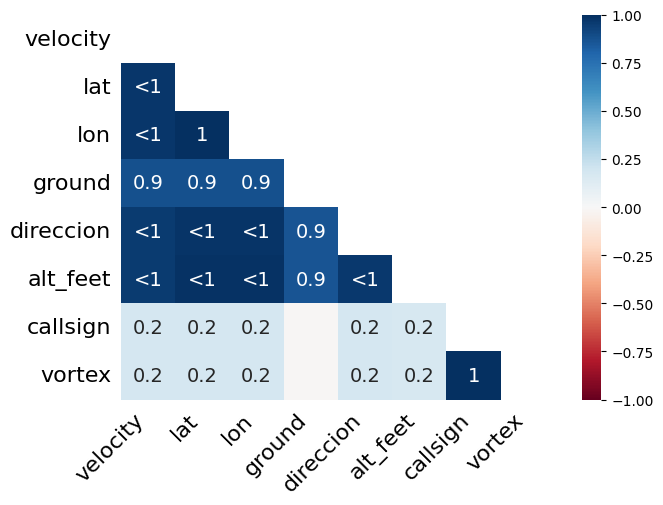

In [8]:
import missingno as msno 

msno.heatmap(df, figsize=(7,5));

La conclusión que aparece parece ser la de que si hay algún nulo en alguna columna, en las demás también habrá un nulo seguramente, de modo que tenemos:
1. Filas donde todos los datos están completos.
2. Filas donde todos los datos están vacíos.

In [9]:
print("ANTES:", df.shape)
df_lat_lon = df[~df.lat.isna() & ~df.lon.isna()]
print("DESPUES:", df_lat_lon.shape)

ANTES: (952775, 11)
DESPUES: (546763, 11)


In [10]:
df_lat_lon.isna().sum()

ts_kafka         0
velocity      5926
lat              0
lon              0
icao             0
ground       13543
direccion     9364
alt_feet      7234
callsign     46158
vortex       46157
date_time        0
dtype: int64

In [11]:
df_lat_lon.icao.value_counts().sort_values(ascending=False)

icao
344115    6941
3453cc    1341
34324e    1273
34750f    1238
344195    1222
          ... 
074128       1
508116       1
033689       1
1d74ad       1
62e2fe       1
Name: count, Length: 3651, dtype: int64

In [12]:
print("TAMAÑO DATOS:", df_lat_lon.shape)
print("VALORES UNICOS LONGITUD:", df_lat_lon.lon.unique().shape)
print("VALORES UNICOS LATITUD:", df_lat_lon.lat.unique().shape)

TAMAÑO DATOS: (546763, 11)
VALORES UNICOS LONGITUD: (255880,)
VALORES UNICOS LATITUD: (169671,)


In [13]:
medium_de_aire = df_lat_lon[(df_lat_lon.vortex == 'Medium 1 (between 7000 kg and 34000 kg)') & (df_lat_lon.ground == 1)].icao.unique()
medium_de_tierra = df_lat_lon[(df_lat_lon.vortex == 'Medium 1 (between 7000 kg and 34000 kg)') & (df_lat_lon.ground == 0)].icao.unique()
icaos = set(medium_de_aire).intersection(set(medium_de_tierra))
df_lat_lon[df_lat_lon.icao.isin(icaos)].icao.value_counts()
df_lat_lon[df_lat_lon.icao == '355316']

,ts_kafka,velocity,lat,lon,icao,ground,direccion,alt_feet,callsign,vortex,date_time
610175,1.733397e+12,0.0,40.475441,-3.571213,355316,1.0,NaN,NaN,CONDR91_,Medium 1 (between 7000 kg and 34000 kg),2024-12-05 11:02:45.853
610181,1.733397e+12,0.0,40.475418,-3.571167,355316,0.0,NaN,1525.0,CONDR91_,Medium 1 (between 7000 kg and 34000 kg),2024-12-05 11:08:58.146
610182,1.733397e+12,0.0,40.475418,-3.571167,355316,0.0,1.570796,1525.0,CONDR91_,Medium 1 (between 7000 kg and 34000 kg),2024-12-05 11:09:58.963
610183,1.733397e+12,0.0,40.475418,-3.571167,355316,NaN,1.570796,1525.0,CONDR91_,Medium 1 (between 7000 kg and 34000 kg),2024-12-05 11:10:59.192
610184,1.733397e+12,0.0,40.475448,-3.571181,355316,0.0,1.897008,1525.0,CONDR91_,Medium 1 (between 7000 kg and 34000 kg),2024-12-05 11:11:59.671
610185,1.733397e+12,0.0,40.475418,-3.571167,355316,0.0,1.407690,1525.0,CONDR91_,Medium 1 (between 7000 kg and 34000 kg),2024-12-05 11:13:00.126
610186,1.733397e+12,0.0,40.475418,-3.571167,355316,NaN,1.407690,1525.0,CONDR91_,Medium 1 (between 7000 kg and 34000 kg),2024-12-05 11:14:00.553
610187,1.733397e+12,0.0,40.475448,-3.571181,355316,NaN,1.897008,1525.0,CONDR91_,Medium 1 (between 7000 kg and 34000 kg),2024-12-05 11:14:03.537
610189,1.733397e+12,0.0,40.475441,-3.571198,355316,1.0,2.202079,NaN,CONDR91_,Medium 1 (between 7000 kg and 34000 kg),2024-12-05 11:17:15.587


### Velocidad

In [14]:
df_velocity = df_lat_lon[~df_lat_lon.velocity.isna()]
df_velocity

,ts_kafka,velocity,lat,lon,icao,ground,direccion,alt_feet,callsign,vortex,date_time
56,1.733120e+12,175.0,40.516042,-3.574614,34254b,0.0,NaN,2275.0,GLJ77C__,Medium 1 (between 7000 kg and 34000 kg),2024-12-02 06:10:18.991
57,1.733120e+12,214.0,40.571020,-3.583728,34254b,0.0,1.735041,5750.0,GLJ77C__,Medium 1 (between 7000 kg and 34000 kg),2024-12-02 06:11:19.172
58,1.733120e+12,222.0,40.611055,-3.644465,34254b,0.0,2.381638,9650.0,GLJ77C__,Medium 1 (between 7000 kg and 34000 kg),2024-12-02 06:12:19.064
59,1.733120e+12,249.0,40.647675,-3.707886,34254b,0.0,2.603044,12900.0,GLJ77C__,Medium 1 (between 7000 kg and 34000 kg),2024-12-02 06:13:19.290
60,1.733120e+12,327.0,40.590991,-3.768061,34254b,0.0,2.683053,14575.0,GLJ77C__,Medium 1 (between 7000 kg and 34000 kg),2024-12-02 06:14:19.292
...,...,...,...,...,...,...,...,...,...,...,...
952769,1.733358e+12,477.0,39.326294,-7.016024,aabbd0,0.0,2.829769,35025.0,AVA047__,Heavy (larger than 136000 kg),2024-12-05 00:18:41.171
952770,1.733358e+12,477.0,39.275116,-7.173535,aabbd0,0.0,2.827805,35800.0,AVA047__,Heavy (larger than 136000 kg),2024-12-05 00:19:41.509
952771,1.733358e+12,481.0,39.223659,-7.331848,aabbd0,0.0,2.827217,36375.0,AVA047__,Heavy (larger than 136000 kg),2024-12-05 00:20:41.448
952772,1.733358e+12,483.0,39.173904,0.342845,aabbd0,0.0,0.010122,36925.0,AVA047__,Heavy (larger than 136000 kg),2024-12-05 00:21:41.850


In [15]:
df_velocity.icao.value_counts().sort_values(ascending=False)

icao
344115    6941
3453cc    1337
34324e    1267
34750f    1232
344195    1214
          ... 
405a4a       1
4910cb       1
44008f       1
3444cf       1
4d2453       1
Name: count, Length: 3442, dtype: int64

Cogemos el avión con más filas de datos, ICAO 344115

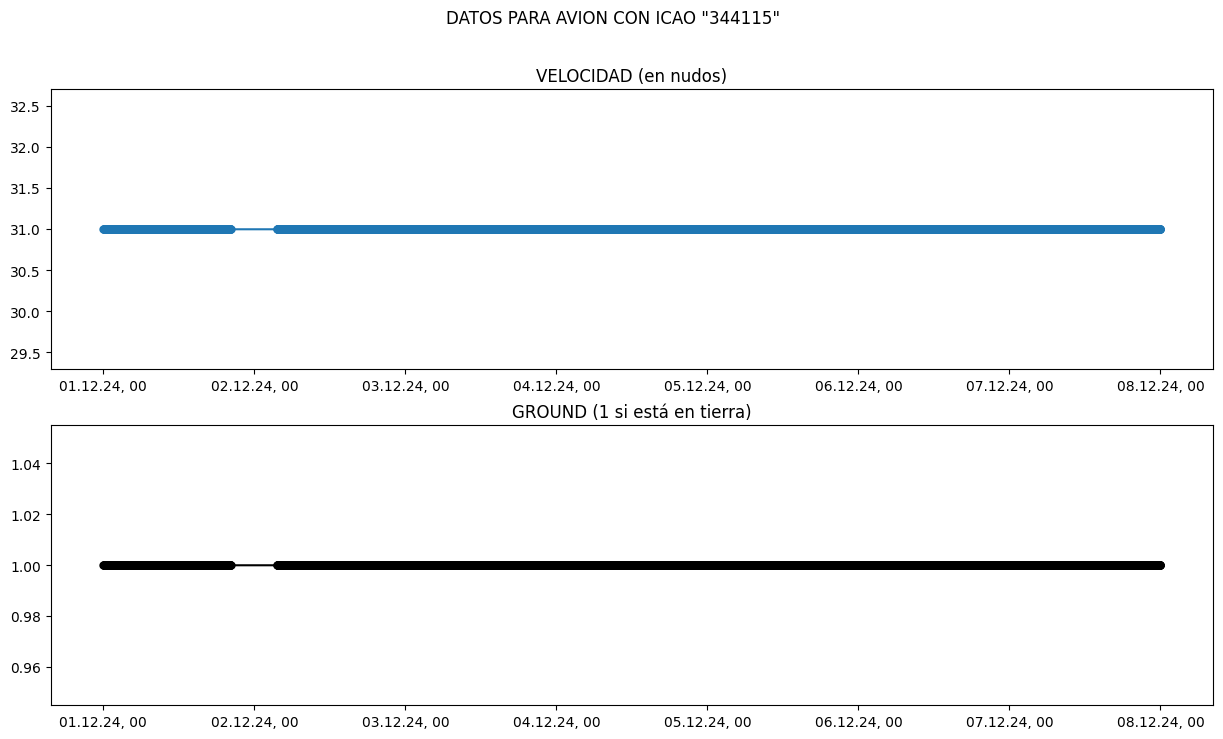

In [16]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_velocity_ground(data, icao):
    data = data[data.icao == icao]
    fig, axs = plt.subplots(2,1, figsize=(15, 8))
    axs[0].plot(data.date_time, data.velocity, marker='o', linestyle='-', markersize=5) 
    axs[1].plot(data.date_time, data.ground, color="black", marker='o', linestyle='-', markersize=5) 
    axs[0].set_title('VELOCIDAD (en nudos)')
    axs[1].set_title('GROUND (1 si está en tierra)')
    fig.suptitle(f'DATOS PARA AVION CON ICAO "{icao}"')
    myFmt = mdates.DateFormatter('%d.%m.%y, %H')
    for ax in axs:
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.xaxis.set_major_formatter(myFmt)

plot_velocity_ground(df_velocity, '344115')

Según las gráficas, el avión con ICAO 344115 está en tierra y se mueve con la misma velocidad durante 7 horas, algo bastante extraño

Pasamos a ver otro avión, el segundo con más datos, ICAO 02019d

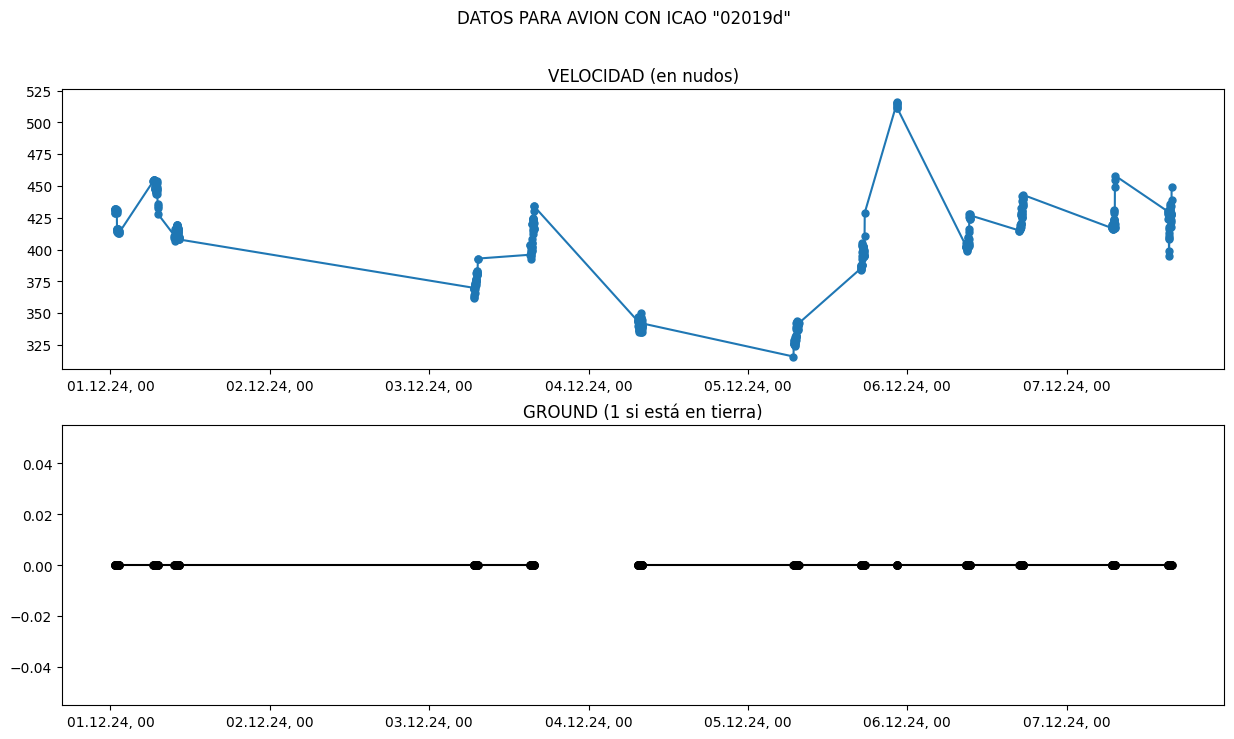

In [17]:
plot_velocity_ground(df_velocity, '02019d')

En este caso es un avión que no aterriza/despega en Madrid, sino que lo atraviesa (ground siempre 0). Pillamos dos de sus vuelos, uno a la 1 de la mañana, otro a las 7. En cuanto a velocidad, no hay un patrón que podamos destacar.

Intentamos encontrar un avión que ha estado en tierra y en aire

In [18]:
ground_icaos = df_velocity[df_velocity.ground == 1.0].icao.unique()
flying_icaos = df_velocity[df_velocity.ground == 0].icao.unique()
icaos_ground_fly = set(ground_icaos).intersection(set(flying_icaos))
df_velocity[df_velocity.icao.isin(icaos_ground_fly)].icao.value_counts()

icao
344195    1214
34604b    1114
343650    1072
345597    1051
347481    1050
          ... 
710130      27
491d9a      24
347295      22
355316       9
347614       3
Name: count, Length: 240, dtype: int64

Como son solo 3 aviones, los visualizamos todos

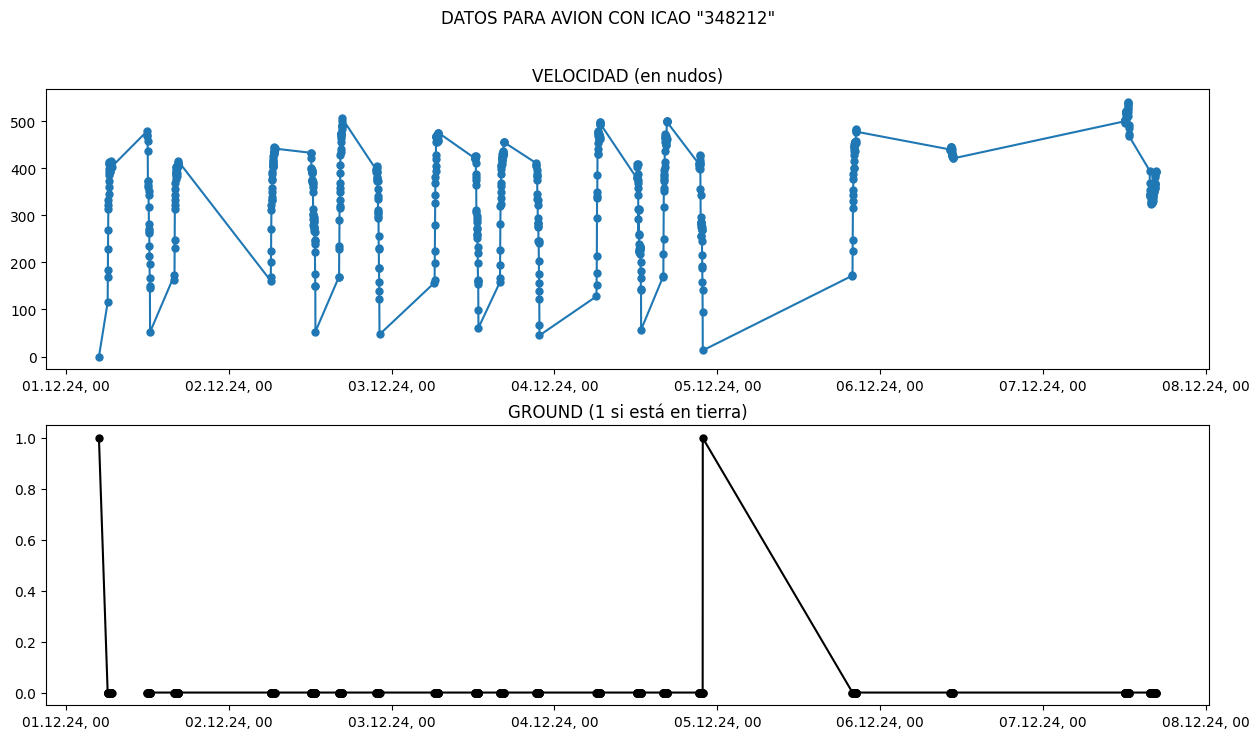

In [19]:
plot_velocity_ground(df_velocity, '348212')

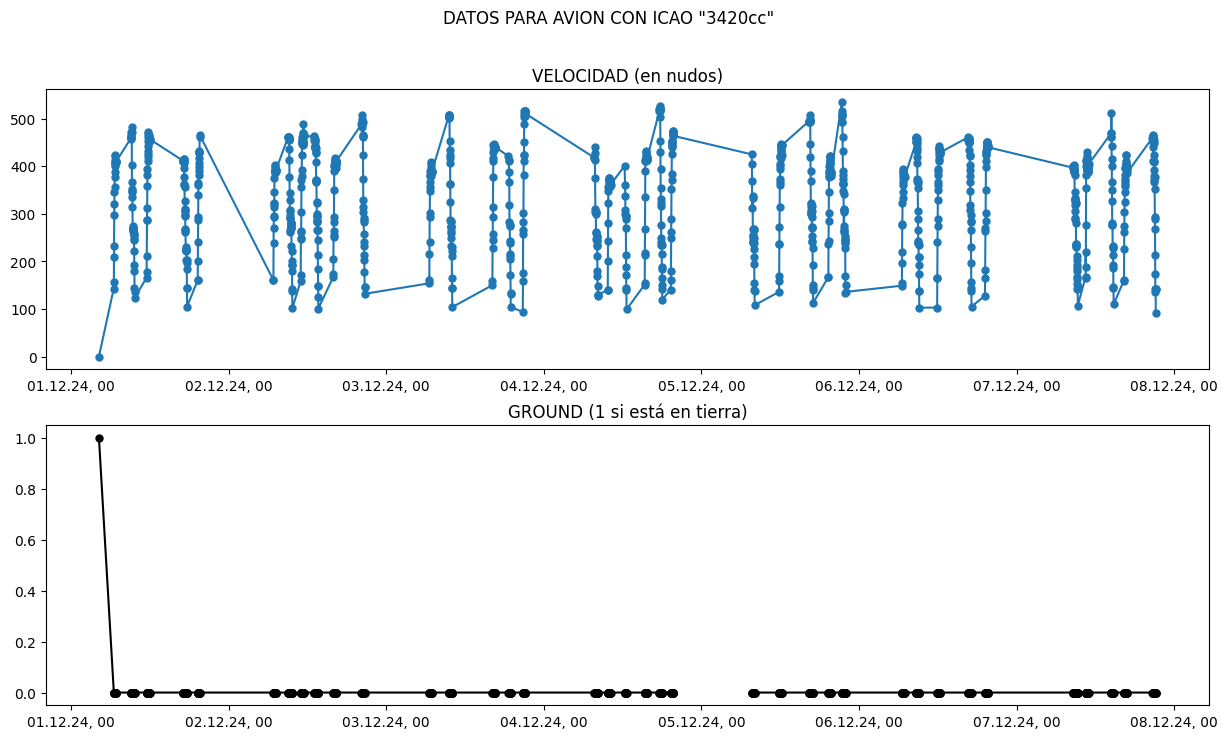

In [20]:
plot_velocity_ground(df_velocity, '3420cc')

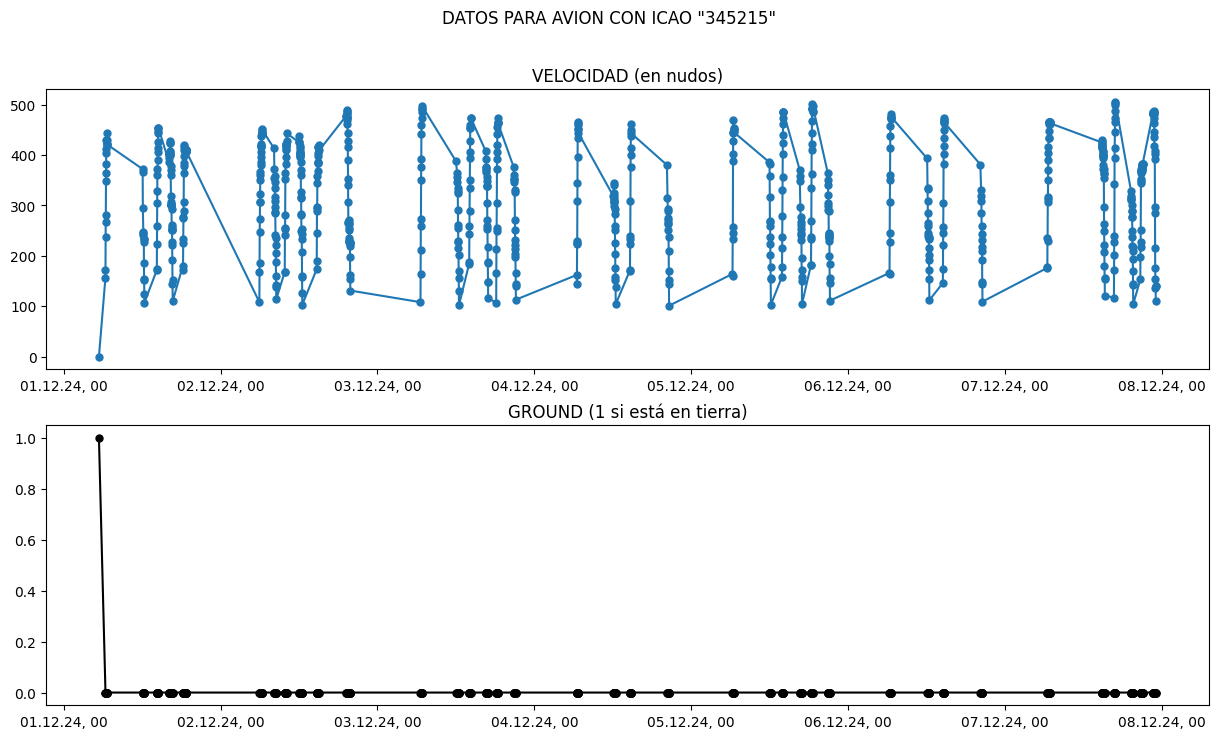

In [21]:
plot_velocity_ground(df_velocity, '345215')

No se captura bien el momento del despegue del avión, puede ser que en ese momento no transmite las coordenadas correctamente

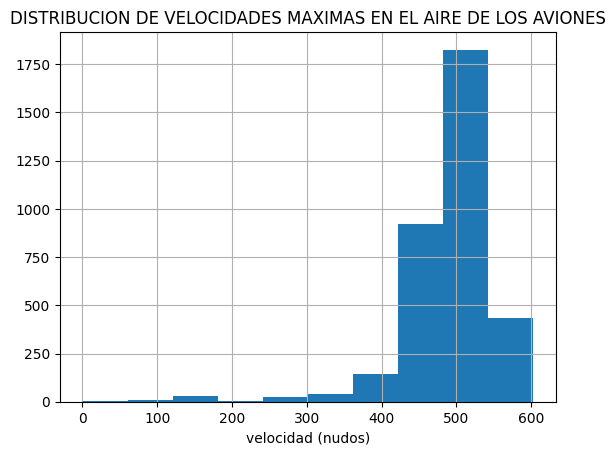

In [22]:
plt.title('DISTRIBUCION DE VELOCIDADES MAXIMAS EN EL AIRE DE LOS AVIONES')
plt.xlabel('velocidad (nudos)')
df_velocity[df_velocity.ground == 0].groupby('icao').max('velocity')['velocity'].hist();


Los aviones con velocidades mas bajas podrian estar aterrizando o despegando

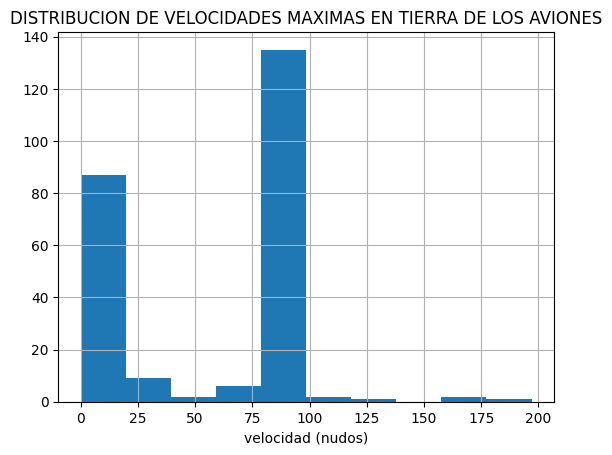

In [23]:
plt.title('DISTRIBUCION DE VELOCIDADES MAXIMAS EN TIERRA DE LOS AVIONES')
plt.xlabel('velocidad (nudos)')
df_velocity[df_velocity.ground == 1.0].groupby('icao').max('velocity')['velocity'].hist();

Vemos que en tierra no suele superar los 15 nudos de velocidad.

### Altura (feets)

In [24]:
df_altitude = df_lat_lon[~df_lat_lon.alt_feet.isna()]
df_altitude

,ts_kafka,velocity,lat,lon,icao,ground,direccion,alt_feet,callsign,vortex,date_time
56,1.733120e+12,175.0,40.516042,-3.574614,34254b,0.0,NaN,2275.0,GLJ77C__,Medium 1 (between 7000 kg and 34000 kg),2024-12-02 06:10:18.991
57,1.733120e+12,214.0,40.571020,-3.583728,34254b,0.0,1.735041,5750.0,GLJ77C__,Medium 1 (between 7000 kg and 34000 kg),2024-12-02 06:11:19.172
58,1.733120e+12,222.0,40.611055,-3.644465,34254b,0.0,2.381638,9650.0,GLJ77C__,Medium 1 (between 7000 kg and 34000 kg),2024-12-02 06:12:19.064
59,1.733120e+12,249.0,40.647675,-3.707886,34254b,0.0,2.603044,12900.0,GLJ77C__,Medium 1 (between 7000 kg and 34000 kg),2024-12-02 06:13:19.290
60,1.733120e+12,327.0,40.590991,-3.768061,34254b,0.0,2.683053,14575.0,GLJ77C__,Medium 1 (between 7000 kg and 34000 kg),2024-12-02 06:14:19.292
...,...,...,...,...,...,...,...,...,...,...,...
952769,1.733358e+12,477.0,39.326294,-7.016024,aabbd0,0.0,2.829769,35025.0,AVA047__,Heavy (larger than 136000 kg),2024-12-05 00:18:41.171
952770,1.733358e+12,477.0,39.275116,-7.173535,aabbd0,0.0,2.827805,35800.0,AVA047__,Heavy (larger than 136000 kg),2024-12-05 00:19:41.509
952771,1.733358e+12,481.0,39.223659,-7.331848,aabbd0,0.0,2.827217,36375.0,AVA047__,Heavy (larger than 136000 kg),2024-12-05 00:20:41.448
952772,1.733358e+12,483.0,39.173904,0.342845,aabbd0,0.0,0.010122,36925.0,AVA047__,Heavy (larger than 136000 kg),2024-12-05 00:21:41.850


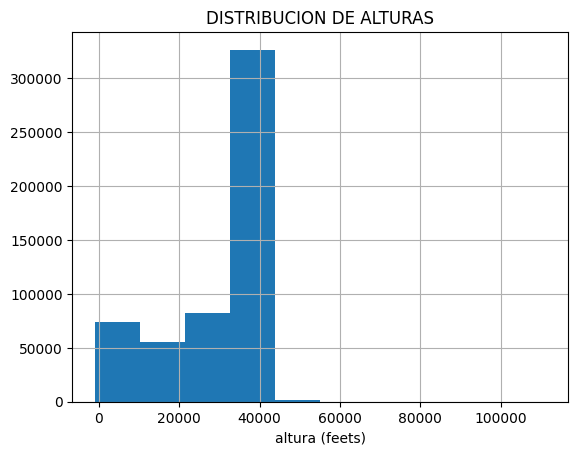

In [25]:
plt.title('DISTRIBUCION DE ALTURAS')
plt.xlabel('altura (feets)')
df_altitude.alt_feet.hist();

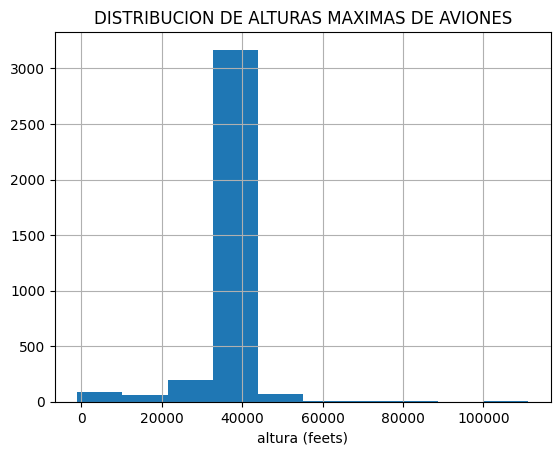

In [26]:
plt.title('DISTRIBUCION DE ALTURAS MAXIMAS DE AVIONES')
plt.xlabel('altura (feets)')
df_altitude.groupby('icao').max('alt_feet')['alt_feet'].hist();

In [27]:
df_altitude.icao.value_counts().sort_values(ascending=False)

icao
3453cc    1341
34324e    1273
344195    1222
34750f    1216
346155    1174
          ... 
26e5c2       1
5d7d97       1
80c390       1
02fb14       1
4b3a49       1
Name: count, Length: 3599, dtype: int64

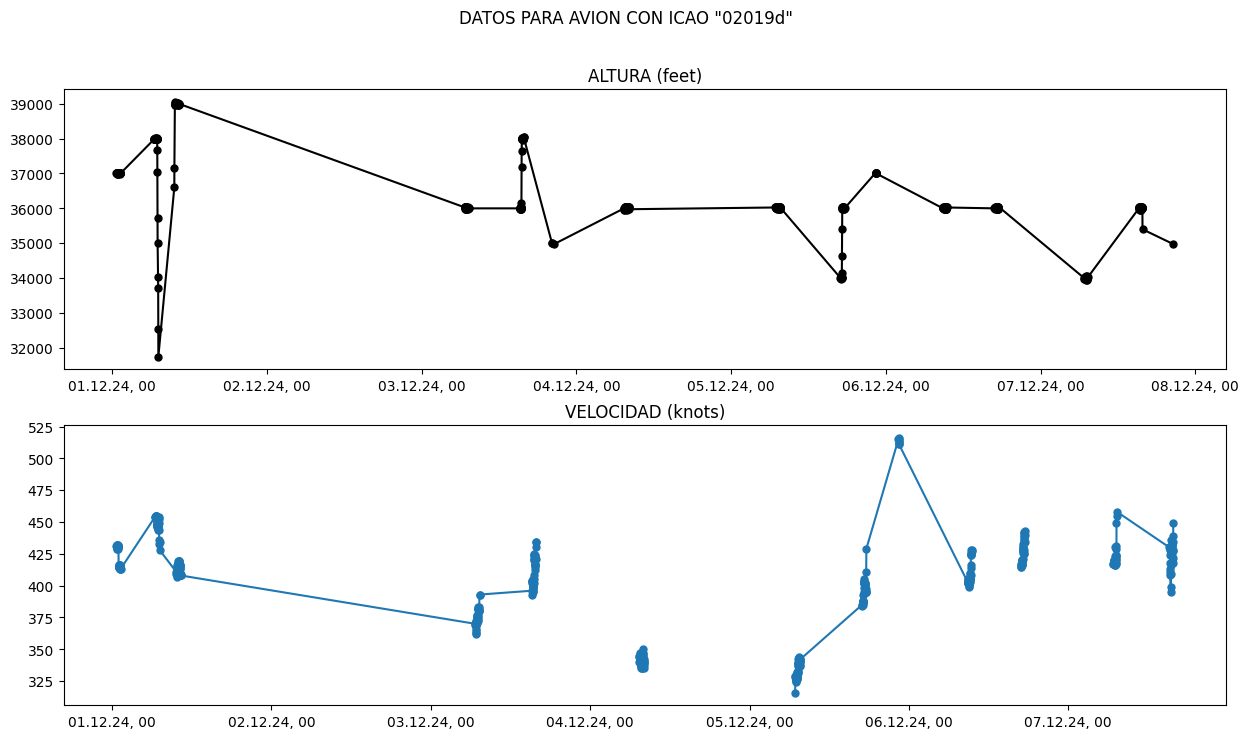

In [28]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_velocity_altitude(data, icao):
    data = data[data.icao == icao]
    fig, axs = plt.subplots(2,1, figsize=(15, 8))
    axs[0].plot(data.date_time, data.alt_feet, color="black", marker='o', linestyle='-', markersize=5) 
    axs[1].plot(data.date_time, data.velocity, marker='o', linestyle='-', markersize=5) 
    axs[0].set_title('ALTURA (feet)')
    axs[1].set_title('VELOCIDAD (knots)')
    fig.suptitle(f'DATOS PARA AVION CON ICAO "{icao}"')
    myFmt = mdates.DateFormatter('%d.%m.%y, %H')
    for ax in axs:
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.xaxis.set_major_formatter(myFmt)



plot_velocity_altitude(df_altitude, '02019d')

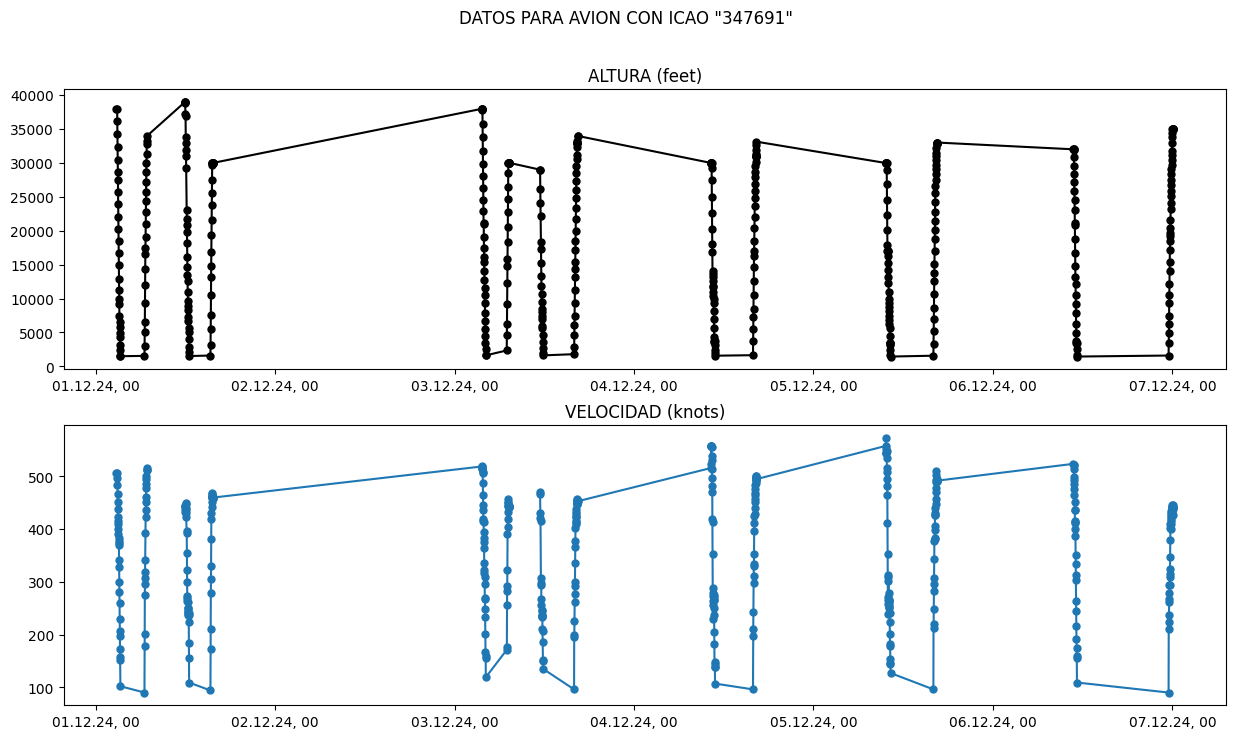

In [29]:
plot_velocity_altitude(df_altitude, '347691')

Este avion parece aterrizar y luego despegar, vemos el `ground`

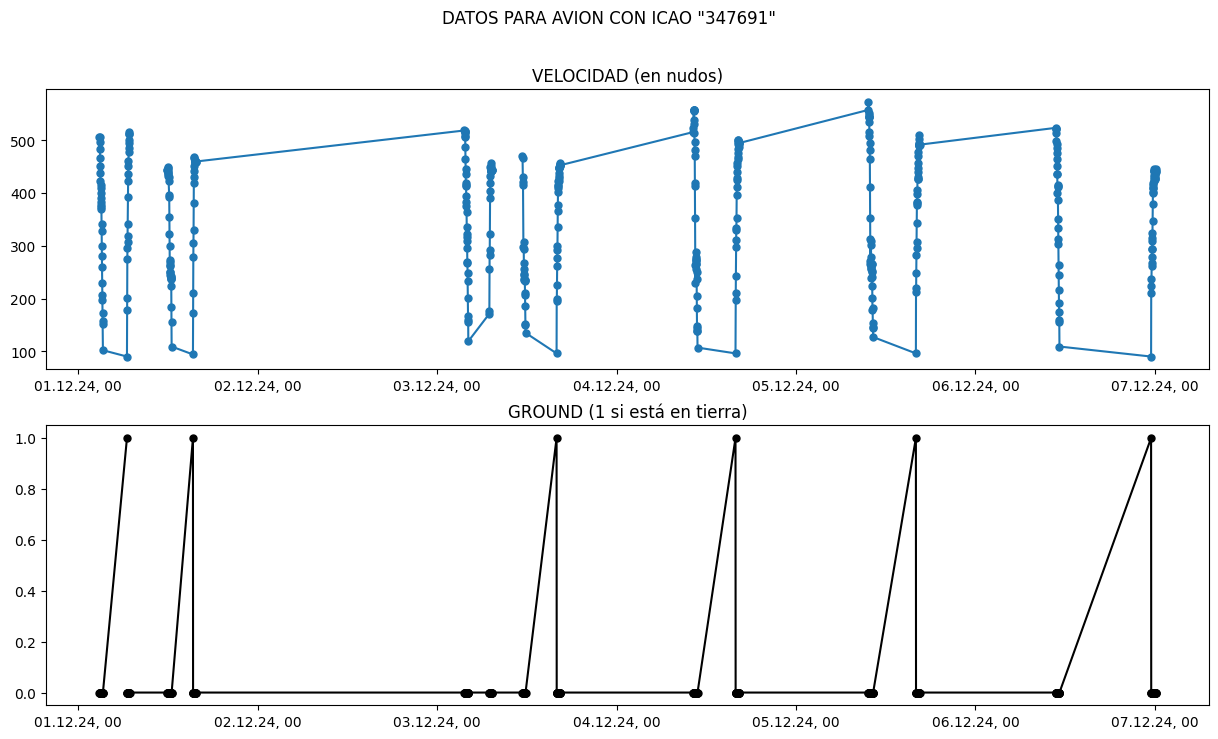

In [30]:
plot_velocity_ground(df_altitude, '347691')

Otra cosa que llama la atención, en el anterior gráfico vimos que la altura era muy baja, pero el onground no llega a 1

In [31]:
df_altitude[df_altitude.ground == 1]

,ts_kafka,velocity,lat,lon,icao,ground,direccion,alt_feet,callsign,vortex,date_time
1803,1.733067e+12,94.0,40.505688,-3.559219,3451d8,1.0,NaN,1600.0,ANE23VD_,Medium 2 (between 34000 kg to 136000 kg),2024-12-01 15:29:22.138
1881,1.733124e+12,92.0,40.505719,-3.559211,3451d8,1.0,NaN,2900.0,ANE86ZR_,Medium 2 (between 34000 kg to 136000 kg),2024-12-02 07:18:35.089
2055,1.733153e+12,90.0,40.505356,-3.559219,3451d8,1.0,NaN,1625.0,ANE71DM_,Medium 2 (between 34000 kg to 136000 kg),2024-12-02 15:15:47.447
2282,1.733240e+12,96.0,40.505696,-3.559227,3451d8,1.0,NaN,1725.0,ANE55UZ_,Medium 2 (between 34000 kg to 136000 kg),2024-12-03 15:27:39.152
2668,1.733559e+12,90.0,40.505344,-3.559219,3451d8,1.0,NaN,1575.0,ANE84YP_,Medium 2 (between 34000 kg to 136000 kg),2024-12-07 08:18:02.060
...,...,...,...,...,...,...,...,...,...,...,...
943378,1.733354e+12,96.0,40.498638,-3.574631,346291,1.0,NaN,1575.0,AEA121__,Heavy (larger than 136000 kg),2024-12-04 23:11:21.499
943465,1.733527e+12,90.0,40.498341,-3.574615,346291,1.0,NaN,1600.0,AEA045__,Heavy (larger than 136000 kg),2024-12-06 23:14:47.431
947321,1.733613e+12,92.0,40.497840,-3.574645,0d0ed6,1.0,NaN,1675.0,AMX022__,Heavy (larger than 136000 kg),2024-12-07 23:01:40.087
952644,1.733041e+12,92.0,40.498558,-3.574631,aabbd0,1.0,NaN,2100.0,AVA027__,Heavy (larger than 136000 kg),2024-12-01 08:11:58.003


En `df_altitude` no hay aviones que han estado en tierra